https://tintn.github.io/Implementing-Vision-Transformer-from-Scratch/

In [4]:
!git clone https://github.com/bwa2116/fromScratch.git

Cloning into 'fromScratch'...
remote: Enumerating objects: 525, done.
remote: Counting objects: 100% (89/89), done.
remote: Compressing objects: 100% (89/89), done.
remote: Total 525 (delta 52), reused 0 (delta 0), pack-reused 436
Receiving objects: 100% (525/525), 1.53 MiB | 10.26 MiB/s, done.
Resolving deltas: 100% (319/319), done.


In [5]:
cd /content/fromScratch

/content/fromScratch


In [6]:
# from vit import ViTForClassfication
from vit_favor import ViTForClassfication
from utils import save_experiment

import torch
torch.cuda.empty_cache()


import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

In [7]:
exp_name = 'vit-with-20-epochs'
batch_size = 64
epochs = 1
lr = 1e-4
save_model_every = 0

import torch
from torch import nn, optim
from config import config_CIFAR10, config_MNIST, config_Places365, config_ImageNet200

device = "cuda" if torch.cuda.is_available() else "cpu"

config = config_CIFAR10

# These are not hard constraints, but are used to prevent misconfigurations
assert config["hidden_size"] % config["num_attention_heads"] == 0
assert config['intermediate_size'] == 4 * config['hidden_size']
assert config['image_size'] % config['patch_size'] == 0


class Trainer:
    """
    The simple trainer.
    """

    def __init__(self, model, optimizer, loss_fn, exp_name, device):
        self.model = model.to(device)
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.exp_name = exp_name
        self.device = device

    def train(self, trainloader, testloader, epochs, save_model_every_n_epochs=0):
        """
        Train the model for the specified number of epochs.
        """
        # Keep track of the losses and accuracies
        train_losses, test_losses, accuracies = [], [], []
        # Train the model
        for i in range(epochs):
            train_loss = self.train_epoch(trainloader)
            accuracy, test_loss = self.evaluate(testloader)
            train_losses.append(train_loss)
            test_losses.append(test_loss)
            accuracies.append(accuracy)
            print(f"Epoch: {i+1}, Train loss: {train_loss:.4f}, Test loss: {test_loss:.4f}, Accuracy: {accuracy:.4f}")
            if save_model_every_n_epochs > 0 and (i+1) % save_model_every_n_epochs == 0 and i+1 != epochs:
                print('\tSave checkpoint at epoch', i+1)
                save_checkpoint(self.exp_name, self.model, i+1)
        # Save the experiment
        save_experiment(self.exp_name, config, self.model, train_losses, test_losses, accuracies)

    def train_epoch(self, trainloader):
        """
        Train the model for one epoch.
        """
        self.model.train()
        total_loss = 0
        for batch in trainloader:
            # Move the batch to the device
            batch = [t.to(self.device) for t in batch]
            images, labels = batch
            # Zero the gradients
            self.optimizer.zero_grad()
            # Calculate the loss
            loss = self.loss_fn(self.model(images)[0], labels)
            # Backpropagate the loss
            loss.backward()
            # Update the model's parameters
            self.optimizer.step()
            total_loss += loss.item() * len(images)
        return total_loss / len(trainloader.dataset)

    @torch.no_grad()
    def evaluate(self, testloader):
        self.model.eval()
        total_loss = 0
        correct = 0
        with torch.no_grad():
            for batch in testloader:
                # Move the batch to the device
                batch = [t.to(self.device) for t in batch]
                images, labels = batch

                # Get predictions
                logits, _ = self.model(images)

                # Calculate the loss
                loss = self.loss_fn(logits, labels)
                total_loss += loss.item() * len(images)

                # Calculate the accuracy
                predictions = torch.argmax(logits, dim=1)
                correct += torch.sum(predictions == labels).item()
        accuracy = correct / len(testloader.dataset)
        avg_loss = total_loss / len(testloader.dataset)
        return accuracy, avg_loss

In [8]:
from prepare_data import prepare_CIFAR10_data, prepare_MNIST_data, prepare_Places365_data, prepare_ImageNet200_data

# Training parameters
save_model_every_n_epochs = save_model_every
# Load the  dataset
trainloader, testloader, _ = prepare_CIFAR10_data(batch_size=batch_size)
# Create the model, optimizer, loss function and trainer
model = ViTForClassfication(config)
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-2)
loss_fn = nn.CrossEntropyLoss()
trainer = Trainer(model, optimizer, loss_fn, exp_name, device=device)
trainer.train(trainloader, testloader, epochs, save_model_every_n_epochs=save_model_every_n_epochs)

100%|██████████| 170498071/170498071 [00:06<00:00, 27678164.69it/s]


Extracting ../data/cifar-10-python.tar.gz to ../data
Files already downloaded and verified


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 1, Train loss: 1.7491, Test loss: 1.6406, Accuracy: 0.3921


# Inspect

In [ ]:
from utils import visualize_images, visualize_attention, load_experiment

100%|██████████| 9912422/9912422 [00:00<00:00, 213864627.13it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 29617529.05it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 79414502.87it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 3641156.11it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



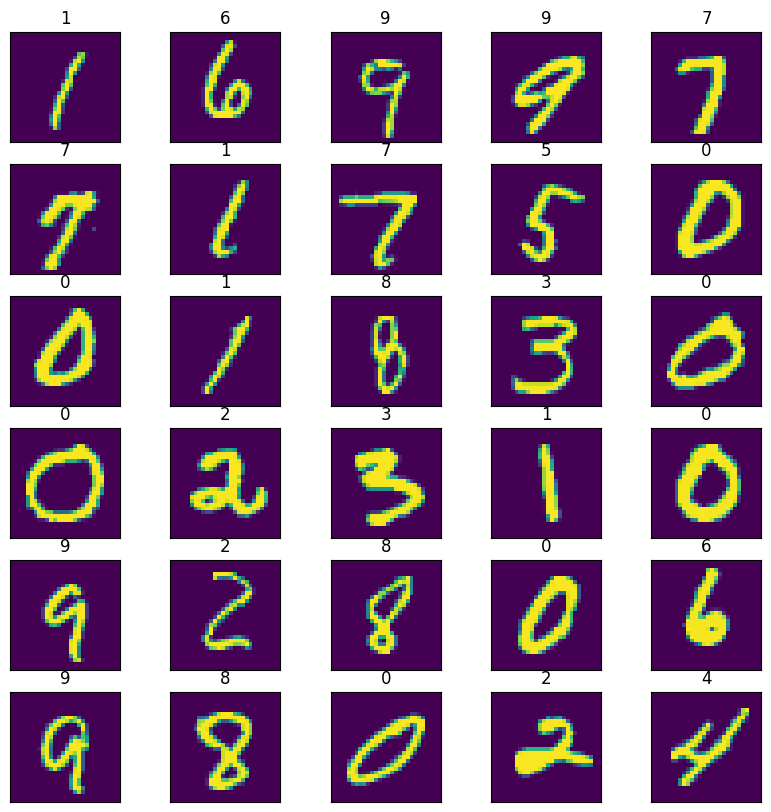

In [ ]:
visualize_images('MNIST') # Show some training images

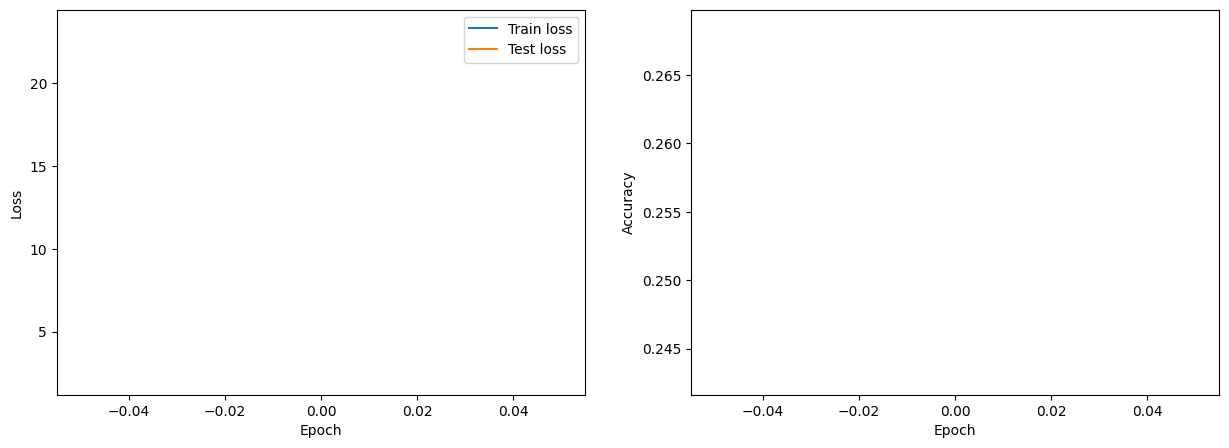

In [ ]:
# Load Experiment
config, model, train_losses, test_losses, accuracies = load_experiment("vit-with-20-epochs")

import matplotlib.pyplot as plt
# Create two subplots of train/test losses and accuracies
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(train_losses, label="Train loss")
ax1.plot(test_losses, label="Test loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend()
ax2.plot(accuracies)
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
plt.savefig("metrics.png")
plt.show()

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:153: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


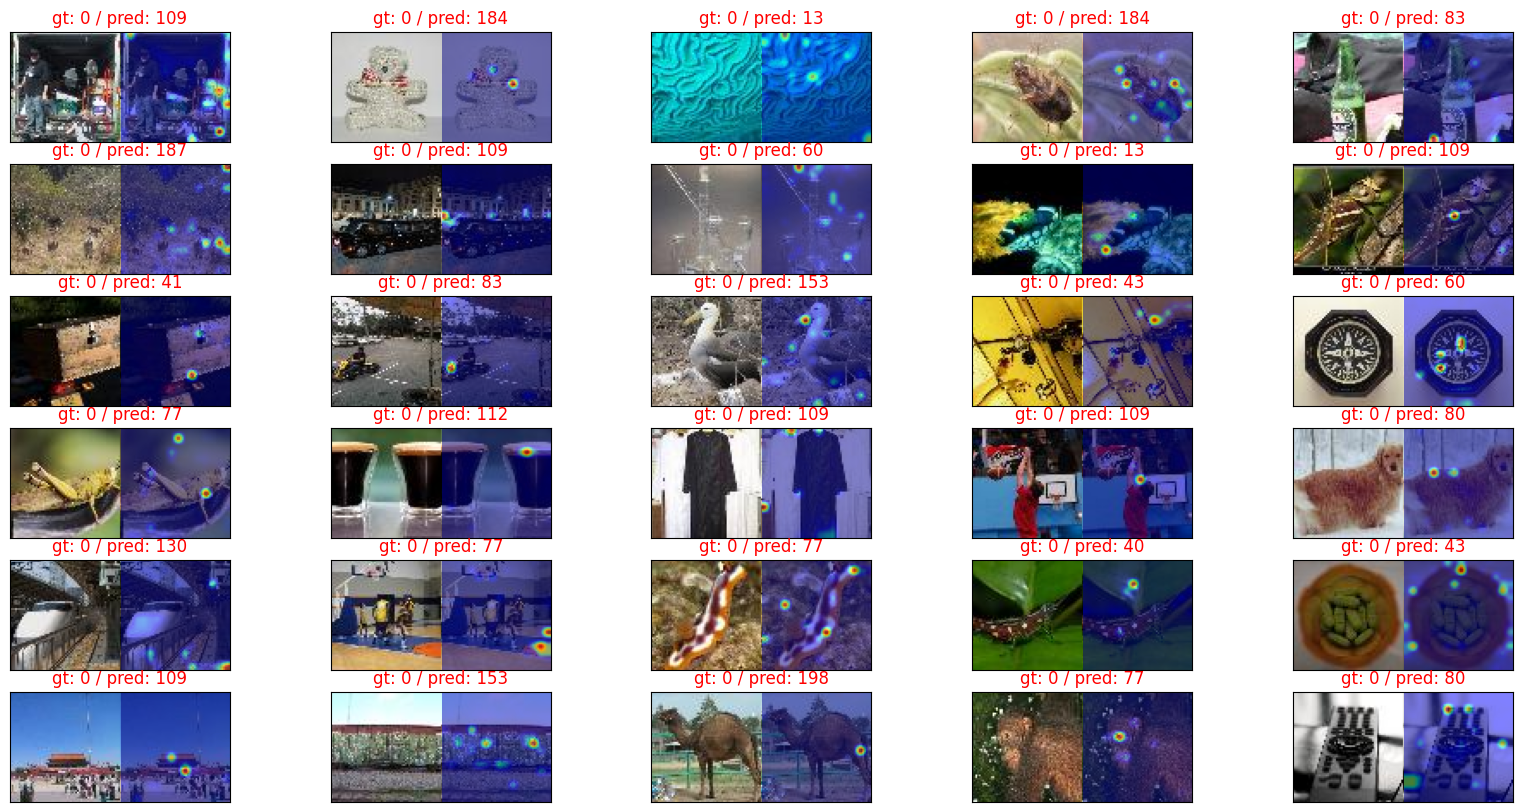

In [ ]:
visualize_attention(model,'ImageNet200', "attention.png")